In [85]:
import os
import cv2
import time
import numpy as np
from PIL import Image
import mediapipe as mp
import matplotlib.pyplot as plt

In [120]:
.shape

(130, 640, 3)

In [116]:
data_path   = './data'
icon_source = [
    'icons/arrow.png',    
    'icons/bow.png',
    'icons/shield.png',
    'icons/circle.png',
]
show_source = [
    'show.png'
]
IQ          = 5   # Image quality:画质等级，数字越大越差0, 1, 2, 3, 5
SEP         = 30  # Septal:图标间距的像素值
R           = 60  # 触碰圆半径
H           = 480 # 图片的高
W           = 640 # 图片的宽
LC          = (int(640*1/2), int(480/3))  # 左侧触碰圆圆心
RC          = (int(640*3/4), int(480/3))  # 右侧触碰圆圆心
icons       = []  # 存储图标
icons_index = []  # 图标索引
show_data   = np.zeros((130,640,3))  # 数据展示区域

mp_drawing        = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands          = mp.solutions.hands
for name in icon_source:
    im = Image.open(os.path.join(data_path, name))
    # png转jpg
    im = im.convert('RGB')
    # RGB转BGR格式，并按画质等级降低画质
    if 'circle' in name:
        im = cv2.cvtColor(np.array(im)[::IQ*3,::IQ*3], cv2.COLOR_RGB2BGR)
    else:
        im = cv2.cvtColor(np.array(im)[::IQ,::IQ], cv2.COLOR_RGB2BGR)
    icons.append(im)
    icons_index.append(np.where(im != 0))

In [87]:
def get_landmarks(multi_hand_landmarks):
    '''
    将mediapipe的识别结果转换为列表形式方便操作
    multi_hand_landmarks:多手坐标results.multi_hand_landmarks
    '''
    land_marks = []
    for hand_landmarks in multi_hand_landmarks:
        tmp = str(hand_landmarks).replace('\n', '').replace('{', '').replace('landmark  ', '').replace('}', ' ').replace('  ', ' ').replace(':', '')[1:-1].split(' ')
        land_marks.append([(float(tmp[i+1]), float(tmp[i+3]), float(tmp[i+5])) for i in range(0, len(tmp), 6)])
    return land_marks

def get_label(multi_handedness):
    '''
    得到mediapipe对左右手的识别结果
    multi_handedness:识别标签results.multi_handedness
    '''
    hands_info = {}
    index      = 0
    for hand_info in multi_handedness:
        hand_info = str(hand_info).replace('\n', '').replace('  ',' ').replace('"', '').replace('}', '')
        hand_info = hand_info.split(' ')
        hands_info[hand_info[7]] = (index, float(hand_info[5]))
        index += 1
    return hands_info

def chartlet(img ,icon, quality=1, icon_index=None):
    '''
    向原图贴加图标，原理是从原图和图标中的像素值加权后相加得到叠加图像
    img:        array待叠加的图像
    icon:       array待叠加的图标
    quality:    0.0-1.0图标的透明度
    icons_index:图标中的有效部分
    '''
    if not icon_index:
        icon_index = np.where(icon != 0)
    img  = np.array(img,  np.uint8)
    icon = np.array(icon, np.uint8)
    for i in range(len(icon_index[0])):
        img[icon_index[0][i]][icon_index[1][i]][icon_index[2][i]] = img[icon_index[0][i]][icon_index[1][i]][icon_index[2][i]]*(1 - quality) + icon[icon_index[0][i]][icon_index[1][i]][icon_index[2][i]]*quality
    return img

def show_skill(frame, arrow, bow, shield):
    '''
    在图片上显示技能数量
    frame:       array将要显示的图片
    arrow:       箭的数量
    bow:         弓箭的数量
    shield:      盾的数量
    '''
    for index in range(3):
        h, w = icons[index].shape[:-1]
        frame[SEP:h+SEP, SEP*(index+1)+w*index:SEP*(index+1)+w*(index+1)] = chartlet(frame[SEP:h+SEP, SEP*(index+1)+w*index:SEP*(index+1)+w*(index+1)], icons[index], icon_index=icons_index[index])
        frame = cv2.putText(frame, str(arrow), (SEP*(index+1)+w*index + int(w/3), SEP*2+h), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
    return frame

In [89]:
cap = cv2.VideoCapture(0)
with mp_hands.Hands(
    model_complexity=0,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5) as hands:
    while cap.isOpened():
        success, image = cap.read()
        if not success:
            print("Ignoring empty camera frame.")
            continue
        # 取消图像标记可提升程序性能
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # 将图片翻转
        image = cv2.flip(image, 1)
        # 进行预测
        results = hands.process(image)
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        if results.multi_hand_landmarks != None:
            # 绘制手部关键点图像
            for hand_landmarks in results.multi_hand_landmarks:
                mp_drawing.draw_landmarks(
                    image,
                    hand_landmarks,
                    mp_hands.HAND_CONNECTIONS,
                    mp_drawing_styles.get_default_hand_landmarks_style(),
                    mp_drawing_styles.get_default_hand_connections_style())
            hand_points = get_landmarks(results.multi_hand_landmarks)
            hands_info  = get_label(results.multi_handedness)
            for hand_label in hands_info.keys():
                # 若只出现一只手，则不使用索引
                hand_index = 0
                if len(hand_points) > 1:
                    # 若只出现多只手，则使用索引
                    hand_index = hands_info[hand_label][0]
                tmp_point = (
                    int(hand_points[hand_index][0][0]*image.shape[1]),
                    int(hand_points[hand_index][0][1]*image.shape[0])
                )
                # 绘制左右手的标签、
                image = cv2.putText(image, hand_label, tmp_point, cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        image = show_skill(image,0,0,0)
        cv2.imshow('MediaPipe Hands', image)
        if cv2.waitKey(5) & 0xFF == 27:
            break
cap.release()
cv2.destroyAllWindows()

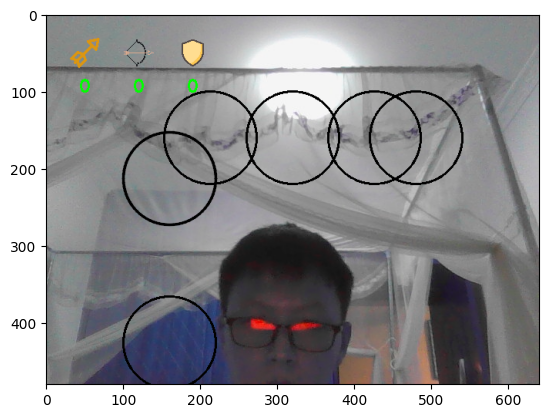

In [113]:
plt.imshow(cv2.circle(image, LC,R, (1,1,1), thickness=2))
plt.imshow(cv2.circle(image, RC,R, (1,1,1), thickness=2))

In [94]:
image.shape[:-1]

(480, 640)

TypeError: VideoCapture.set() missing required argument 'propId' (pos 1)

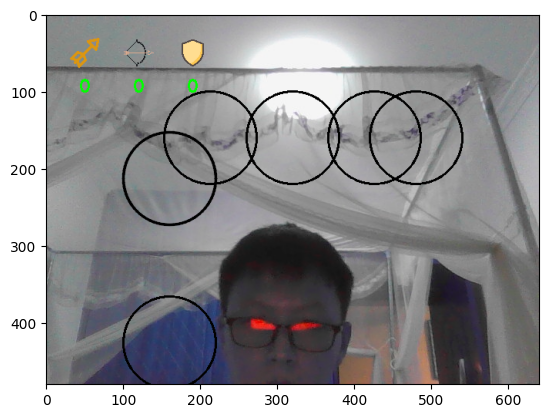

In [115]:
plt.imshow(image)